In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation
import scipy.ndimage as ndimage
import matplotlib.patches as patches
import cv2
import numpy as np
import pandas as pd
import os,gc
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
torch.cuda.set_device(1)
print (torch.cuda.current_device())
#os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3,4,5,6,7"

1


In [2]:
def Image_Processing(img_path, crop_size=224):
    img = Image.open(img_path).convert('RGB').resize((256, 256),Image.ANTIALIAS) #open and resize
    #crop and normalize
    transform_sequence = transforms.Compose([
                                             #transforms.ToPILImage(), #if not PILImage
                                             transforms.CenterCrop(crop_size),
                                             transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
                                             #transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
                                            ])
    img = transform_sequence(img).numpy() #tensor to numpy
    return img

img_path = '/data/fjsdata/NIH-CXR/images/images/' 
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia','Pneumothorax', \
               'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding'] 
#preparing the trainset and  testset
trData = pd.read_csv("/data/fjsdata/NIH-CXR/chexnet_dataset/fjs_train.csv" , sep=',') #trainset
trN, trI, trY = [],[],[]
for _, row in trData.iterrows():
    name = row['image_index']
    target = np.fromstring(row['target_vector'].strip('[').strip(']'), dtype=int, sep=' ') #turn string to numpy.ndarray
    try:
        trN.append(name)#'image_index'
        trY.append(target)#'target_vector'
        img = Image_Processing(os.path.join(img_path, name))
        trI.append(img)
    except:
        print(name+":"+str(os.path.join(img_path, name)))
    sys.stdout.write('\r{} / {} '.format(len(trN),trData.shape[0]))
    sys.stdout.flush()
print('The length of trainset is %d'%len(trN))
trI = np.array(trI)
trY = np.array(trY)

teData = pd.read_csv("/data/fjsdata/NIH-CXR/chexnet_dataset/fjs_test.csv" , sep=',') #testset
teN, teI, teY = [],[],[]
for _, row in teData.iterrows():
    name = row['image_index']
    target = np.fromstring(row['target_vector'].strip('[').strip(']'), dtype=int, sep=' ') #turn string to numpy.ndarray
    try:
        teN.append(name)#'image_index'
        teY.append(target)#'target_vector'
        img = Image_Processing(os.path.join(img_path, name))
        teI.append(img)
    except:
        print(name+":"+str(os.path.join(img_path, name)))
    sys.stdout.write('\r{} / {} '.format(len(teN),teData.shape[0]))
    sys.stdout.flush()
print('The length of testset is %d'%len(teN))
teI = np.array(teI)
teY = np.array(teY)

#preparing bounding box dataset
boxdata = pd.read_csv("/data/fjsdata/NIH-CXR/chexnet_dataset/fjs_BBox.csv" , sep=',')
boxdata = boxdata[['Image Index','Finding Label','Bbox [x', 'y', 'w', 'h]']]
#print('Dataset statistic, records: %d, fields: %d' % (boxdata.shape[0], boxdata.shape[1]))
#print(boxdata.columns.values.tolist())
bbN, bbI, bbY, bBox = [],[],[],[]
for _, row in boxdata.iterrows():
    bbN.append(row['Image Index'])
    
    img = Image_Processing(os.path.join(img_path, row['Image Index']))
    bbI.append(img)
    
    labels = np.zeros(len(CLASS_NAMES))
    labels[CLASS_NAMES.index(row['Finding Label'])] = 1
    bbY.append(labels)
    
    bBox.append(np.array([row['Bbox [x'], row['y'], row['w'], row['h]']])) #xywh  
print('The length of boxset is %d'%len(bbN))
bbI = np.array(bbI)
bbY = np.array(bbY)
bBox = np.array(bBox)

86524 / 86524 The length of trainset is 86524
25596 / 25596 The length of testset is 25596
The length of testset is 984


In [5]:
# construct model
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet121, self).__init__()
        self.dense_net_121 = torchvision.models.densenet121(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_121.classifier.in_features
        self.dense_net_121.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_121(x)
        return x


class DenseNet169(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet169, self).__init__()
        self.dense_net_169 = torchvision.models.densenet169(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_169.classifier.in_features
        self.dense_net_169.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_169(x)
        return x


class DenseNet201(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet201, self).__init__()
        self.dense_net_201 = torchvision.models.densenet201(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_201.classifier.in_features
        self.dense_net_201.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_201(x)
        return x

In [3]:
#Exclude the multi-label samples.
#index = np.where(np.sum(trY, axis=1) == 1 )[0] 
#trY_ex = trY[index]
#trI_ex = trI[index]
#print(trI_ex.shape)
#index = np.where(np.sum(teY, axis=1) == 0 )[0] 
#teY_ex = teY[index]
#teI_ex = teI[index]
#print(teI_ex.shape)

#Exclude the normal samples.
#index = np.where(np.sum(trY, axis=1) != 0 )[0] 
#trY_ex = trY[index]
#trI_ex = trI[index]
#print(trI_ex.shape)
#index = np.where(np.sum(valY, axis=1) != 0 )[0]
#valY_ex = valY[index]
#valI_ex = valI[index]
#print(valI_ex.shape)
#index = np.where(np.sum(teY, axis=1) != 0 )[0] 
#teY_ex = teY[index]
#teI_ex = teI[index]
#print(teI_ex.shape)

(73471, 3, 224, 224)


In [8]:
#model training
N_CLASSES = len(CLASS_NAMES) #class numbers
model = DenseNet121(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = torch.nn.BCELoss()
#train model
best_net, best_loss = None, float('inf')
batchSize = 30 #'Batch Size': 32
for epoch in range(30):#'Max Epoch': 1000
    losses = []
    losses_tensor = 0.
    num_batches = len(trY_ex) // batchSize + 1
    model.train()  # set network as train mode
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([len(trY_ex), (i+1)*batchSize])
            I_batch = torch.from_numpy(trI_ex[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(trY_ex[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            #forword
            y_outputs = model(I_batch)#permute the dims of matrix， .permute(0, 3, 1, 2)
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : train loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()  
            losses.append(loss.item())
            losses_tensor += loss
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    scheduler.step(losses_tensor.item())
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
model = model.cpu()#release gpu memory
torch.cuda.empty_cache()

 2450 / 2450 : train loss = 0.084531Eopch:     1 mean_loss = 0.130796
 2450 / 2450 : train loss = 0.089218Eopch:     2 mean_loss = 0.129413
 2450 / 2450 : train loss = 0.088989Eopch:     3 mean_loss = 0.128100
 2450 / 2450 : train loss = 0.086895Eopch:     4 mean_loss = 0.127008
 2450 / 2450 : train loss = 0.086608Eopch:     5 mean_loss = 0.126333
 2450 / 2450 : train loss = 0.083976Eopch:     6 mean_loss = 0.125843
 2450 / 2450 : train loss = 0.083819Eopch:     7 mean_loss = 0.125395
 2450 / 2450 : train loss = 0.082631Eopch:     8 mean_loss = 0.125063
 2450 / 2450 : train loss = 0.081936Eopch:     9 mean_loss = 0.124748
 2450 / 2450 : train loss = 0.081191Eopch:    10 mean_loss = 0.124406
 2450 / 2450 : train loss = 0.081776Eopch:    11 mean_loss = 0.124018
 2450 / 2450 : train loss = 0.079924Eopch:    12 mean_loss = 0.123529
 2450 / 2450 : train loss = 0.079781Eopch:    13 mean_loss = 0.123079
 2450 / 2450 : train loss = 0.079891Eopch:    14 mean_loss = 0.122683
 2450 / 2450 : train

In [9]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(teY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(teY), (i+1)*batchSize])
        I_batch = torch.from_numpy(teI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(teY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch)#forword
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()

def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 853 / 854 The average AUROC is 0.6309
The AUROC of Atelectasis is 0.6403
The AUROC of Cardiomegaly is 0.7442
The AUROC of Effusion is 0.7229
The AUROC of Infiltration is 0.4320
The AUROC of Mass is 0.6042
The AUROC of Nodule is 0.5919
The AUROC of Pneumonia is 0.5650
The AUROC of Pneumothorax is 0.6701
The AUROC of Consolidation is 0.6357
The AUROC of Edema is 0.6933
The AUROC of Emphysema is 0.6278
The AUROC of Fibrosis is 0.6304
The AUROC of Pleural_Thickening is 0.6453
The AUROC of Hernia is 0.6670
The AUROC of No Finding is 0.5938


In [6]:
#performance of box
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(bbY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(bbY), (i+1)*batchSize])
        I_batch = torch.from_numpy(np.array(bbI)[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(np.array(bbY)[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch)#forword，.permute(0, 3, 1, 2)
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in [0, 1, 2, 3, 4, 5, 6, 7]:
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in [0, 1, 2, 3, 4, 5, 6, 7]:
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 32 / 33 The average AUROC is 0.6730
The AUROC of Atelectasis is 0.6175
The AUROC of Cardiomegaly is 0.8681
The AUROC of Effusion is 0.7031
The AUROC of Infiltration is 0.6221
The AUROC of Mass is 0.6242
The AUROC of Nodule is 0.6927
The AUROC of Pneumonia is 0.5331
The AUROC of Pneumothorax is 0.7235


(-0.5, 223.5, 223.5, -0.5)

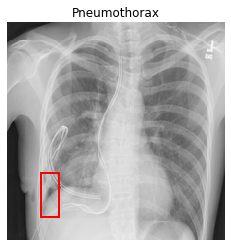

In [7]:
bidx = 890
raw_img = Image.open(os.path.join(img_path, bbN[bidx])).convert('RGB')
width, height = raw_img.size   # Get dimensions
x_scale = 256/width
y_scale = 256/height
raw_img = raw_img.resize((256, 256),Image.ANTIALIAS)
width, height = raw_img.size   # Get dimensions
left = (width - 224)/2
top = (height - 224)/2
right = (width + 224)/2
bottom = (height + 224)/2
crop_del = (256-224)/2
raw_img = raw_img.crop((left, top, right, bottom)) 
raw_img= np.array(raw_img)
#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(raw_img)
x, y, w, h = int(bBox[bidx][0])*x_scale-crop_del, int(bBox[bidx][1])*y_scale-crop_del, int(bBox[bidx][2])*x_scale, int(bBox[bidx][3])*y_scale
rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes

img_label = np.array(CLASS_NAMES)[np.where(bbY[bidx]==1)[0]]
plt.title(img_label[0]) #show labels
plt.axis('off')

0.0851 -> Infiltration
0.0835 -> No Finding
0.0681 -> Effusion
0.0667 -> Atelectasis
0.0660 -> Nodule
0.0647 -> Consolidation
0.0642 -> Pneumothorax
0.0641 -> Mass
0.0637 -> Edema
0.0633 -> Emphysema
0.0631 -> Pleural_Thickening
0.0624 -> Pneumonia
0.0620 -> Cardiomegaly
0.0617 -> Fibrosis
0.0613 -> Hernia


(-0.5, 223.5, 223.5, -0.5)

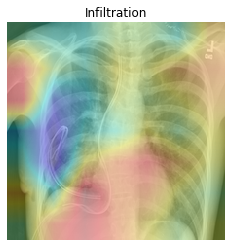

In [9]:
network_model = best_net.dense_net_121.features
network_model.eval()  # set network as evaluation model
best_net.eval()
with torch.autograd.no_grad():
    input_img = torch.from_numpy(bbI[bidx]).type(torch.FloatTensor).cuda()
    input_img = input_img.unsqueeze_(0)
    var_output = network_model(input_img)#forword
    logit = best_net(input_img)#forword
    h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
    probs, idx = h_x.sort(0, True) #probabilities of classe
        
cls_weights = list(best_net.parameters())
weight_softmax = np.squeeze(cls_weights[-2].data.cpu().numpy()) 
classes = {0: 'Atelectasis', 1: 'Cardiomegaly', 2: 'Effusion', 3: 'Infiltration', 4:'Mass', 5:'Nodule', 6:'Pneumonia',\
           7:'Pneumothorax',8:'Consolidation',9:'Edema',10:'Emphysema',11:'Fibrosis',12:'Pleural_Thickening',13:'Hernia',14:'No Finding'}
# output: the prediction
for i in range(0, N_CLASSES):
    line = '{:.4f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
    
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 224x224
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape

    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
    #cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    cam_img = cv2.resize(cam_img, size_upsample)
    return cam_img
#get the class activation maps
cam_img = returnCAM(var_output.cpu().data.numpy(), weight_softmax, idx[0].item())
heat_map = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)
output_img = cv2.addWeighted(np.array(raw_img),0.7,heat_map,0.3,0)
plt.imshow(output_img)
plt.title(classes[idx[0].item()]) #show labels
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

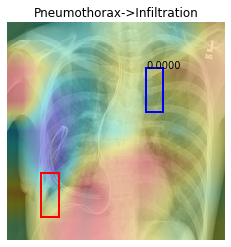

In [10]:
def IOU(xywh1, xywh2):#metric
    x1, y1, w1, h1 = xywh1
    x2, y2, w2, h2 = xywh2

    dx = min(x1+w1, x2+w2) - max(x1, x2)
    dy = min(y1+h1, y2+h2) - max(y1, y2)
    intersection = dx * dy if (dx >=0 and dy >= 0) else 0.
    
    union = w1 * h1 + w2 * h2 - intersection
    return (intersection / union)

# Find local maxima
data = cam_img
neighborhood_size = 100
threshold = .1

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0
#for _ in range(5):
#    maxima = binary_dilation(maxima) 
labeled, num_objects = ndimage.label(maxima)
#slices = ndimage.find_objects(labeled)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))

#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(output_img)
rect = patches.Rectangle((x, y), w, h,linewidth=2, edgecolor='r', facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes
for pt in xy:
    if data[int(pt[0]), int(pt[1])] > np.max(data)*.9:
        x_p = int(max(pt[0], 0.))
        y_p = int(max(pt[1], 0.))
        w_p = int(min(x_p + w, 224)) - x_p
        h_p = int(min(y_p + h, 224)) - y_p
        
        IoU_score = IOU([x,y,w,h],[x_p,y_p,w_p,h_p])
        #print('IoU_score = {:.4f}'.format(IoU_score))
        rect = patches.Rectangle((x_p, y_p), w_p, h_p,linewidth=2, edgecolor='b', facecolor='none')# Create a Rectangle patch
        ax.add_patch(rect)# Add the patch to the Axes
        ax.text(x_p, y_p, '{:.4f}'.format(IoU_score))

plt.title(img_label[0] + '->' + classes[idx[0].item()]) #show labels
#plt.title('Infiltration' + '->' + classes[idx[1].item()]) #show labels
plt.axis('off')

In [10]:
#Assert that there is no patient overlap between the splits
for i in range(len(trN)):
    for j in range(len(teN)):
        if(trN[i].split('_')[0] == teN[j].split('_')[0]):
            print(trN[i])
#for i in range(len(valN)):
#    for j in range(len(teN)):
#        if(valN[i].split('_')[0] == teN[j].split('_')[0]):
#            print(valN[i])